# Predicting Heart Disease Using Classification
#### Group 11: Cameron Geisler, Daisy Liu, Nima Zareian, Sean Chung
## Introduction
This project will use [this dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease), which describes the various attributes, symptoms and observations seen on patients in the process of being diagnosed with cardiovascular heart diseases. 
<br> <br>
Specifically, the project will be using a [processed version](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data) of said data containing information documented by the Cleveland Foundation. Observations made in other locations are also accessible, but this one is more complete than others in that it lacks missing values.
<br> <br>
The processed data omits a significant portion of the variables documented by the original data. The original dataset contains about 76 variables while the processed set only contains 14. For the context of the project, the reprocessed version of the data is chosen because of the lack of proper formatting in the original data which effectively prevented it from being properly imported into R.
<br> <br>
Diagnosis for cardiovascular diseases are often based on direct examinations of the heart done through the use of electrocardiograms (measures heart beat rhythms) and echocardiograms (measures the heart's physical state with ultrasound).
<br> <br>
Aside from these direct testing methods, there are other health metrics which can be used to help predict heart disease.
<br> <br>
Incidentally, almost half of all heart attacks experienced by people were unanticipated due to the presence of asymptomatic heart diseases, that is, heart diseases with little to no experience based indicators, and are thus difficult to notice and diagnose.
<br>

## Preliminary Exploratory Data Analysis

First, we load the necessary packages.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Next, we load the dataset from the [URL](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data).

In [2]:
# Load the dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
data_raw <- read_csv(url, col_names = names)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



The data is already in a tidy format. However, we still make some small changes, to make it more intuitive for human use, and also more suitable for applying various R functions.

In [3]:
# Wrangle data
data <- data_raw %>%
    select(c("age", "trestbps", "thalach", "chol", "num")) %>% # select only columns that are used
    mutate(num = as_factor(num)) %>% # update target variables to factor
    rename(heart_disease = num, # rename some columns with more intuitive names
          rest_bp = trestbps,
          max_heart_rate = thalach)

In the original data, there are five levels of heart disease (labelled 0, 1, 2, 3, 4), which varying degrees of disease, from "no visible heart disease" to "very severe heart disease". We combine levels 1-4, in order to simply classify the observations as having heart diesease (labelled as "Yes") or not (labelled as "No").

In [4]:
data <- data %>%
    mutate(heart_disease = as_factor(ifelse(heart_disease == 0, "No", "Yes")))
data

age,rest_bp,max_heart_rate,chol,heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,150,233,No
67,160,108,286,Yes
67,120,129,229,Yes
⋮,⋮,⋮,⋮,⋮
57,130,115,131,Yes
57,130,174,236,Yes
38,138,173,175,No


Here, we split the data into a training set and testing set, so that future data analysis is solely done on the training set.

In [5]:
set.seed(1) # set the seed

heart_split = initial_split(data, prop = 0.75, strata = heart_disease)
heart_training = training(heart_split)
heart_testing = testing(heart_split)

Below is a bar plot which shows the relative proportion of individuals with and without heart disease in the data set. Notice that the proportions are roughly equal in each category.

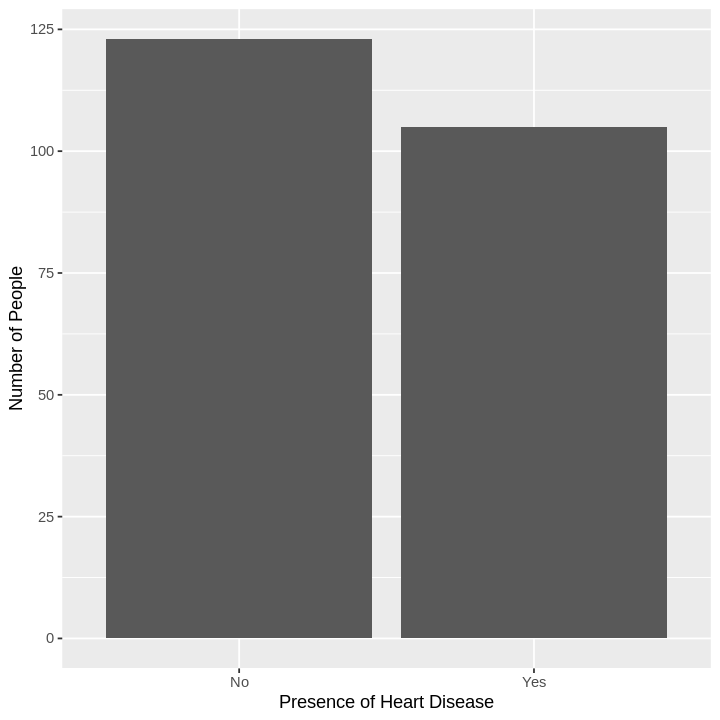

In [6]:
options(repr.plot.width = 6, repr.plot.height = 6)

ggplot(heart_training, aes(x = heart_disease)) +
    geom_bar() +
    xlab("Presence of Heart Disease") +
    ylab("Number of People")

Below are histograms for the four possible predictor variables: age, blood cholesterol, maximum heart rate, and resting blood pressure. Each of the graphs are split up into the groups of people who have heart disease (in blue) and those who don't (in red).
<br><br>
For each variabel, we can roughly compare the distribution between the heart disease and non-heart disease group, to see if the variable seems to be associated with the presence of heart disease. From these plots, it seems that age, resting blood pressure, and cholesterol are positively associated with heart disease (although only slightly), and maximum heart rate is negatively associated with heart disease.

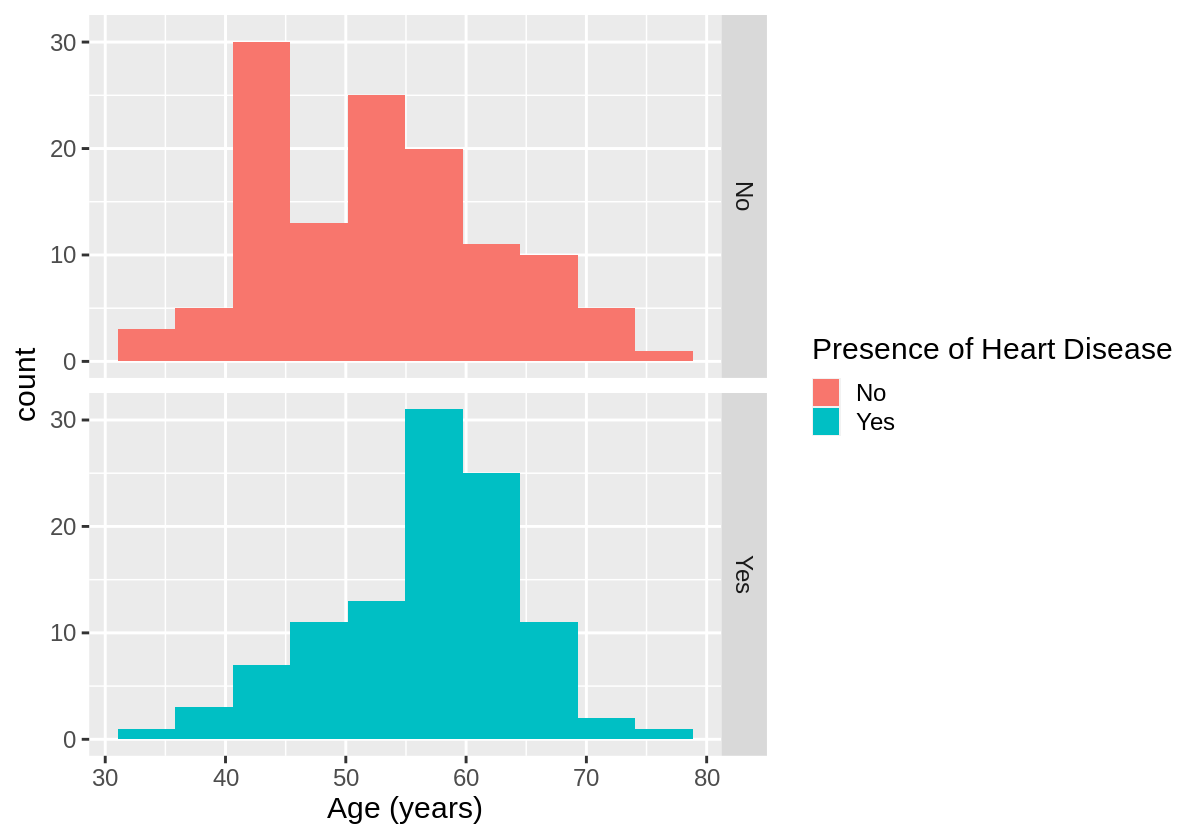

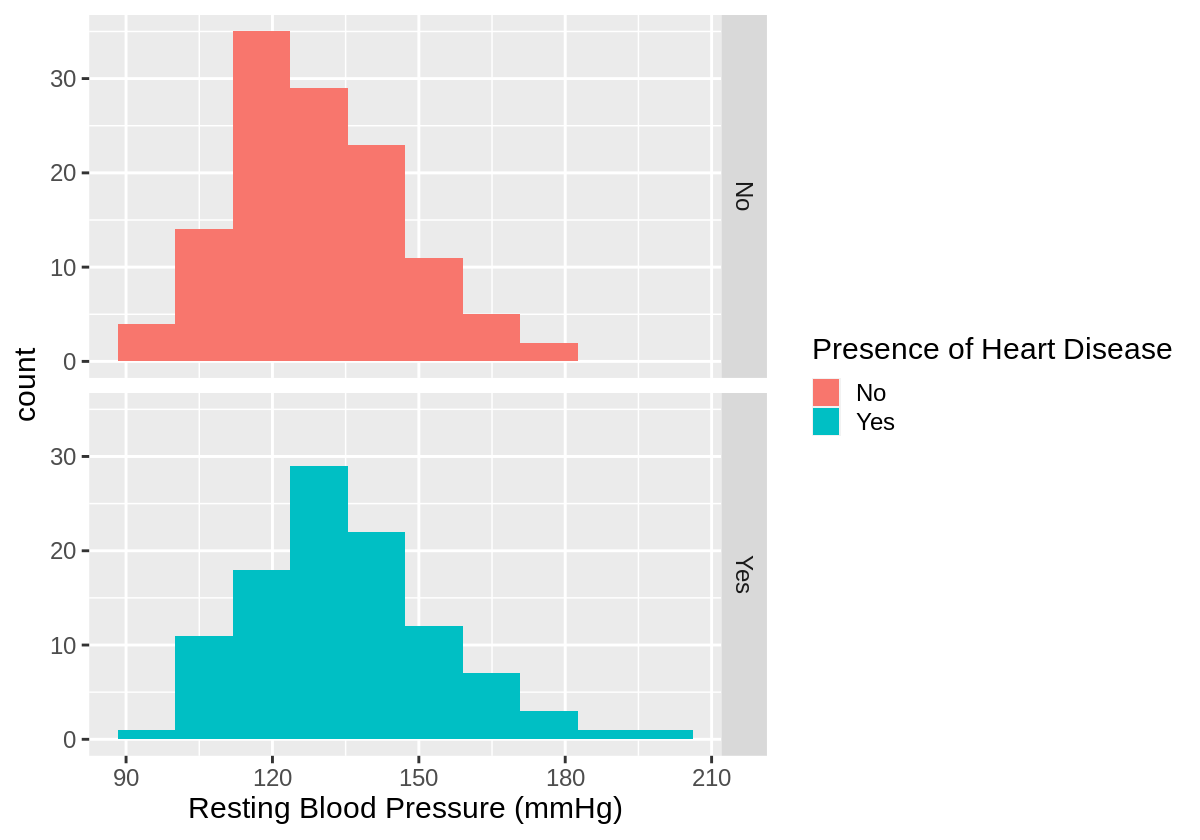

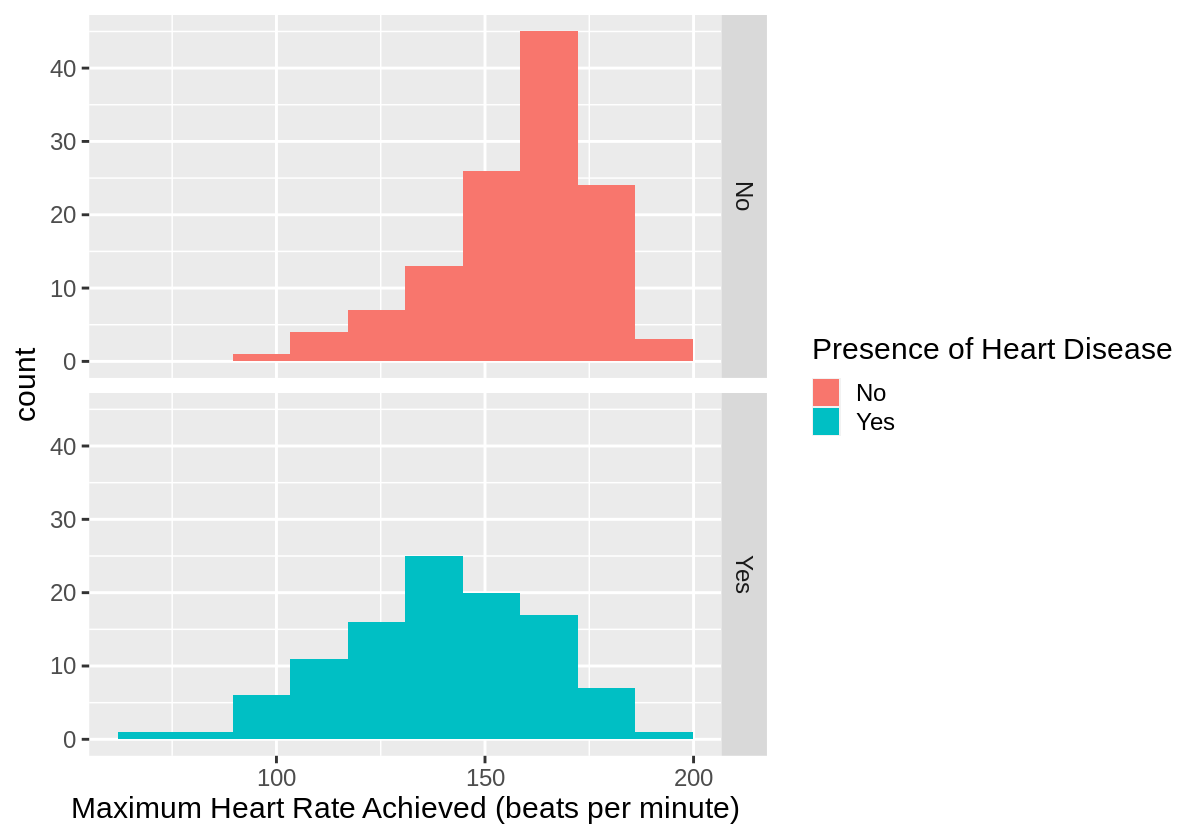

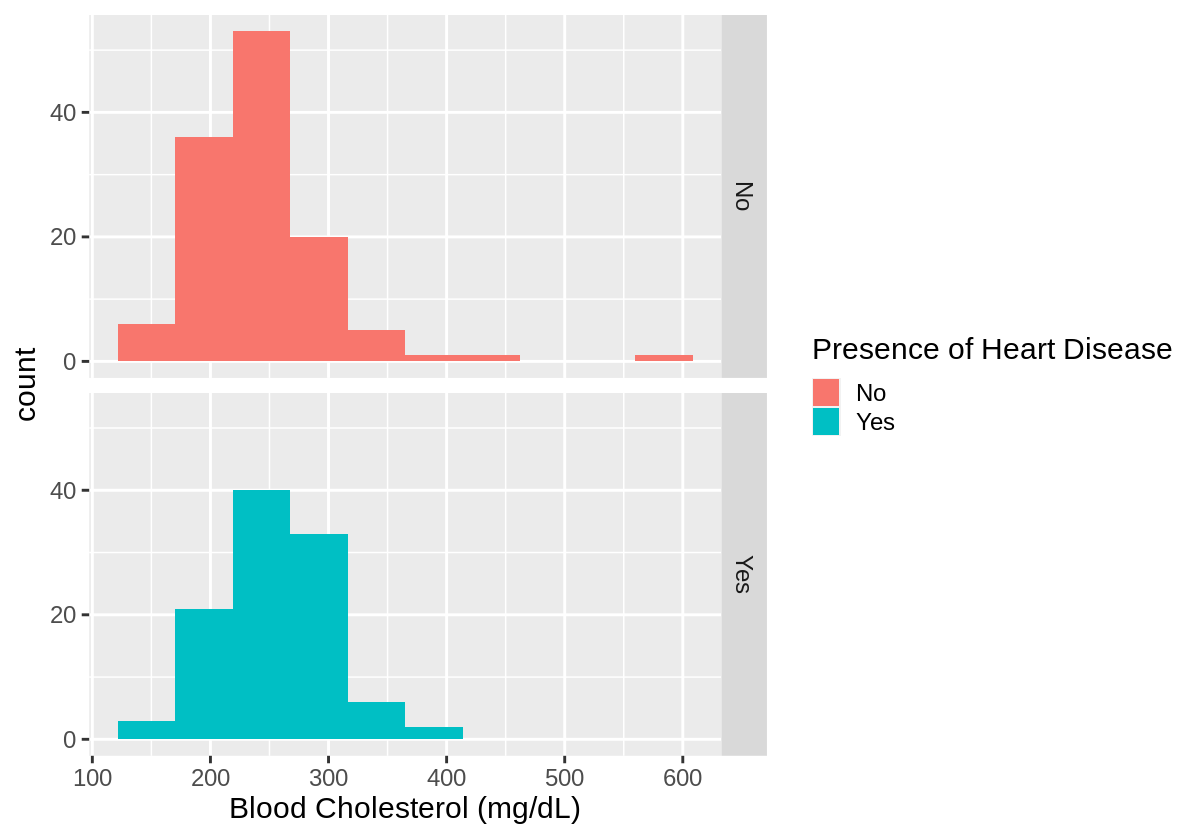

In [7]:
options(repr.plot.width = 10, repr.plot.height = 7)
theme_set(theme_gray(base_size = 18))

# Histograms for (numerical) predictor variables
bins_num = ceiling(log(nrow(data),2))+1 # number of bins, by Sturges' formula
target_var = heart_training$heart_disease

ggplot(heart_training, aes(x = age, fill = target_var)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = target_var) + 
    labs(x = "Age (years)", fill = "Presence of Heart Disease")
ggplot(heart_training, aes(x = rest_bp, fill = target_var)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = target_var) + 
    labs(x = "Resting Blood Pressure (mmHg)", fill = "Presence of Heart Disease")
ggplot(heart_training, aes(x = max_heart_rate, fill = target_var)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = target_var) + 
    labs(x = "Maximum Heart Rate Achieved (beats per minute)", fill = "Presence of Heart Disease")
ggplot(heart_training, aes(x = chol, fill = target_var)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = target_var) + 
    labs(x = "Blood Cholesterol (mg/dL)", fill = "Presence of Heart Disease")

Below are scatterplots for every possible pair of predictor variables (6 in total). However, there isn't a clear pattern for each pair of variables, besides the small patterns for the individual variables.

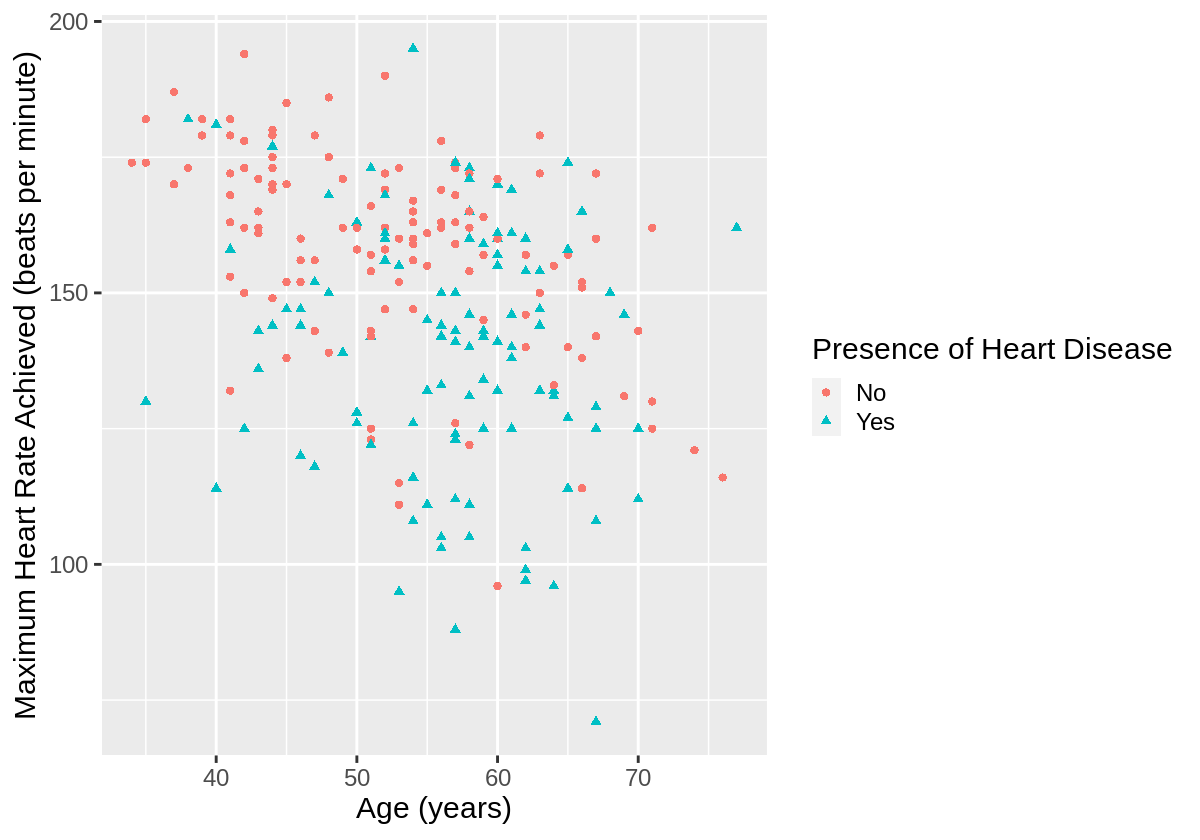

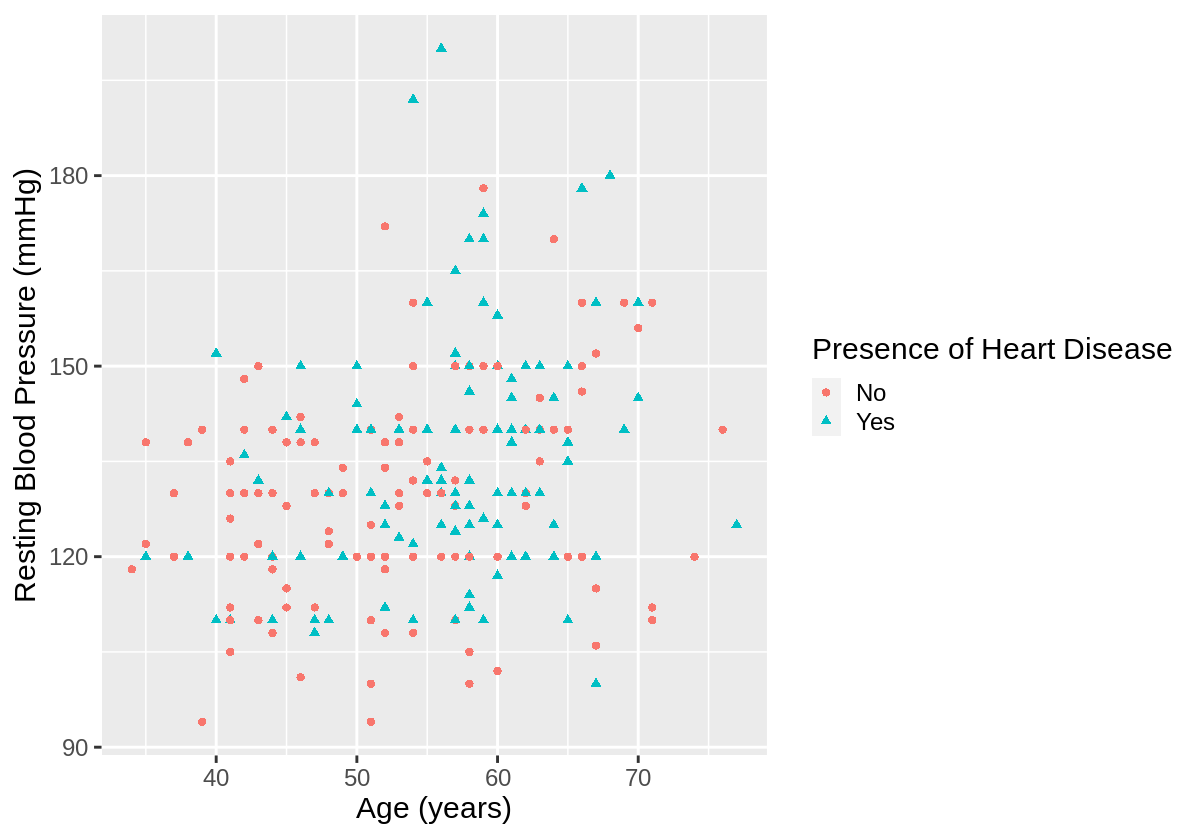

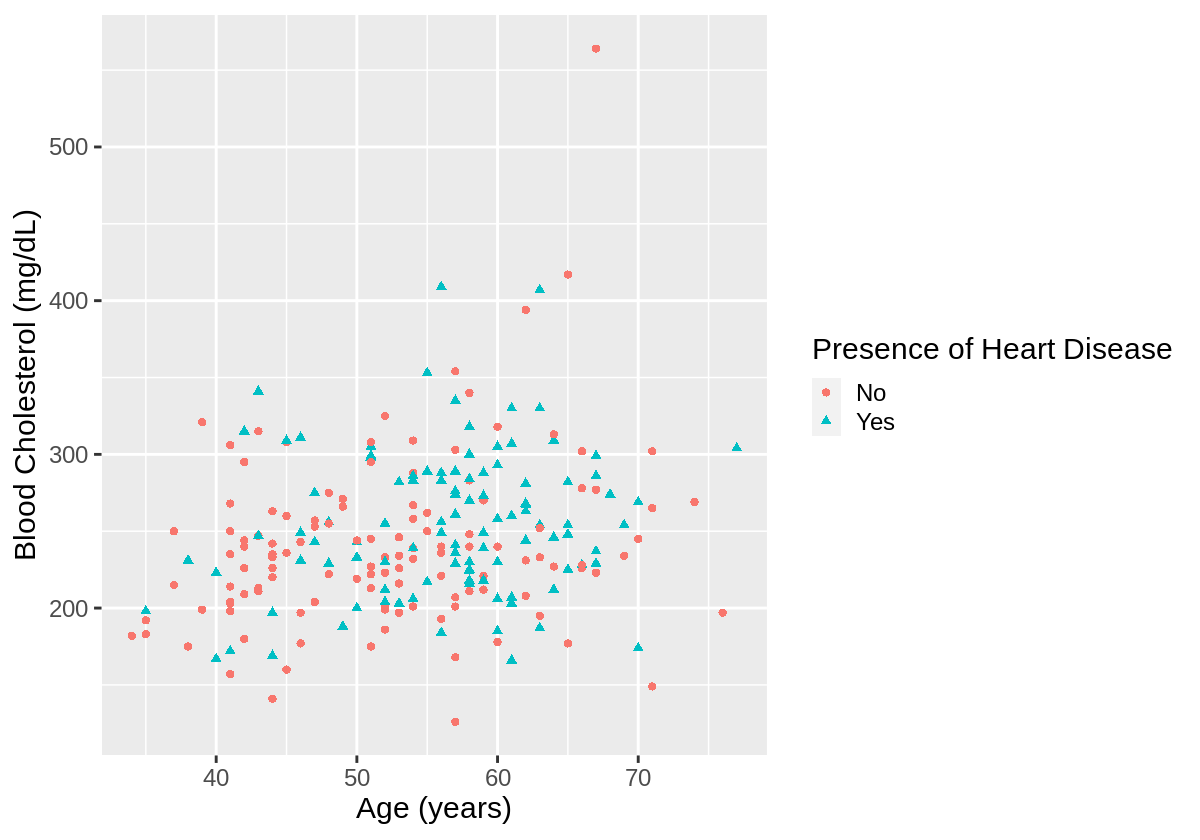

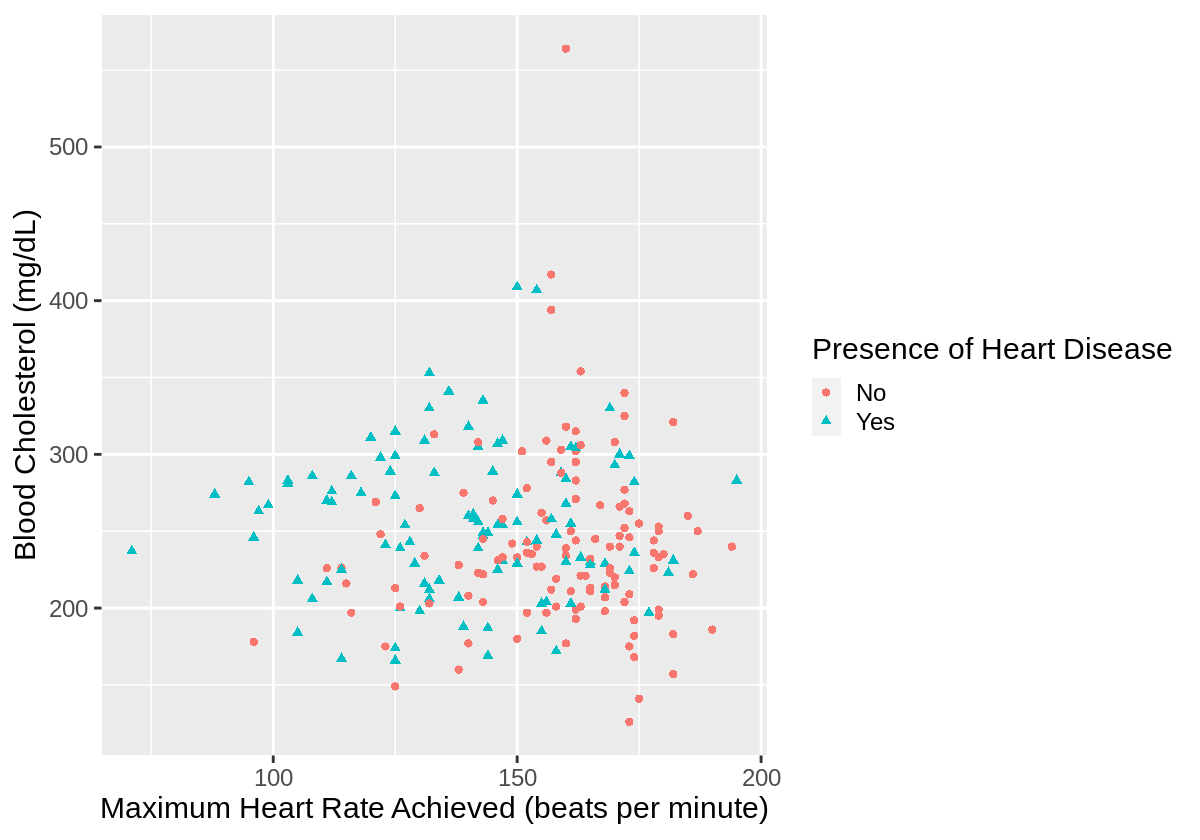

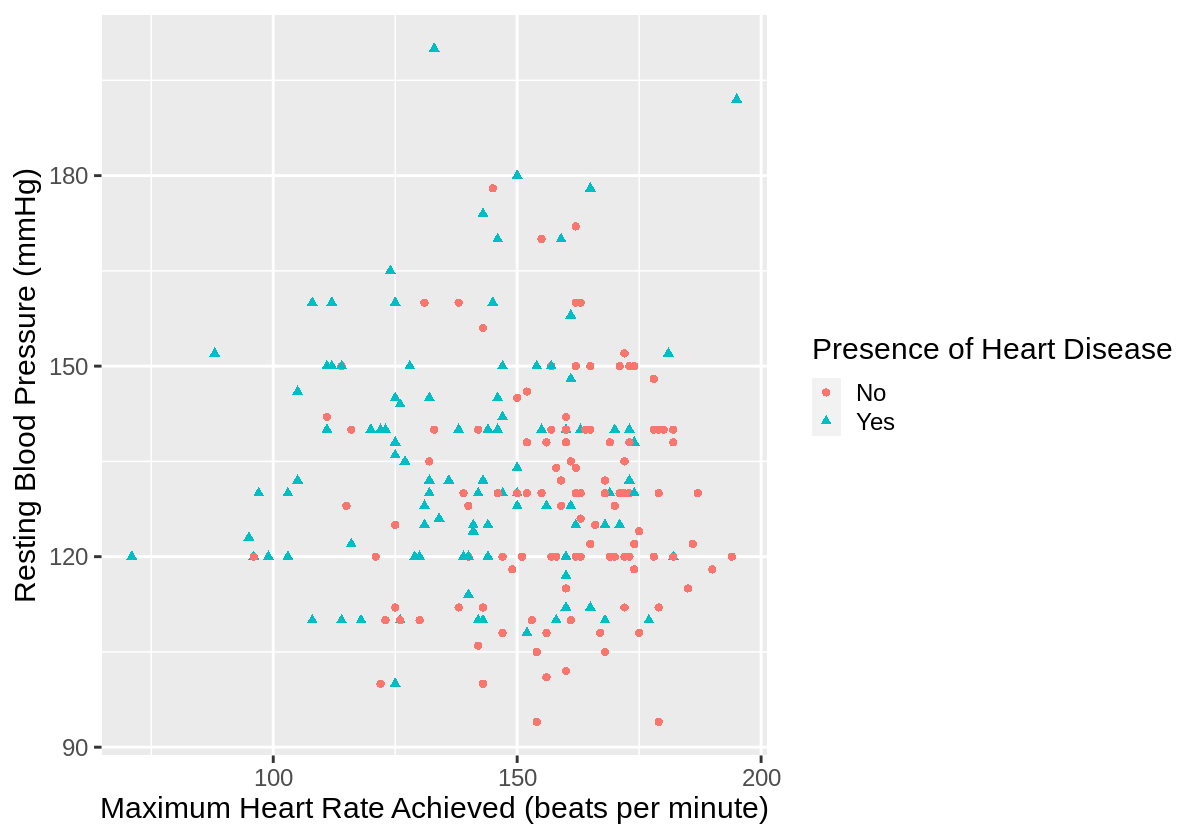

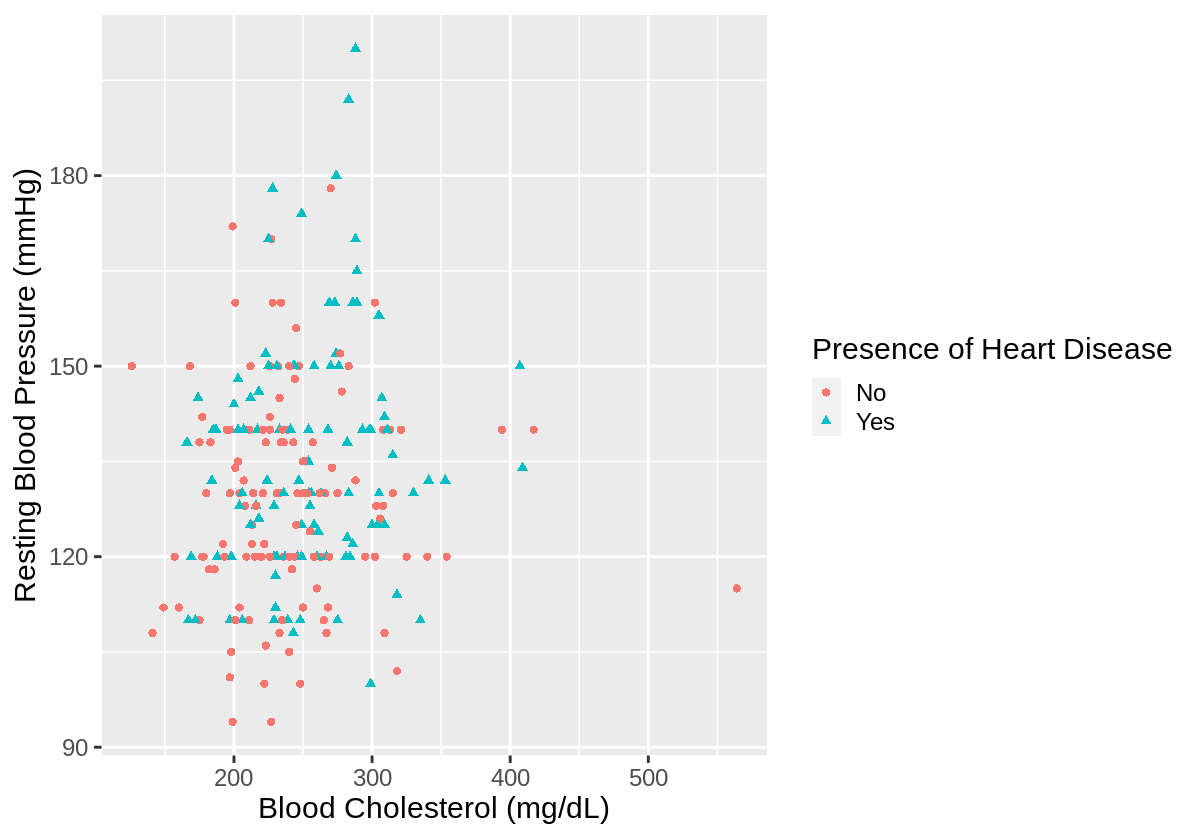

In [8]:
# Scatterplots for every possible combination of predictor variables
ggplot(heart_training, aes(x = age, y = max_heart_rate, shape = heart_disease, color = heart_disease)) +
    geom_point(size = 2) +
    labs(x = "Age (years)", y = "Maximum Heart Rate Achieved (beats per minute)", shape = "Presence of Heart Disease", color = "Presence of Heart Disease")
ggplot(heart_training, aes(x = age, y = rest_bp, shape = heart_disease, color = heart_disease)) +
    geom_point(size = 2) +
    labs(x = "Age (years)", y = "Resting Blood Pressure (mmHg)", shape = "Presence of Heart Disease", color = "Presence of Heart Disease")
ggplot(heart_training, aes(x = age, y = chol, shape = heart_disease, color = heart_disease)) +
    geom_point(size = 2) +
    labs(x = "Age (years)", y = "Blood Cholesterol (mg/dL)", shape = "Presence of Heart Disease", color = "Presence of Heart Disease")
ggplot(heart_training, aes(x = max_heart_rate, y = chol, shape = heart_disease, color = heart_disease)) +
    geom_point(size = 2) +
    labs(x = "Maximum Heart Rate Achieved (beats per minute)", y = "Blood Cholesterol (mg/dL)", shape = "Presence of Heart Disease", color = "Presence of Heart Disease")
ggplot(heart_training, aes(x = max_heart_rate, y = rest_bp, shape = heart_disease, color = heart_disease)) +
    geom_point(size = 2) +
    labs(x = "Maximum Heart Rate Achieved (beats per minute)", y = "Resting Blood Pressure (mmHg)", shape = "Presence of Heart Disease", color = "Presence of Heart Disease")
ggplot(heart_training, aes(x = chol, y = rest_bp, shape = heart_disease, color = heart_disease)) +
    geom_point(size = 2) +
    labs(x = "Blood Cholesterol (mg/dL)", y = "Resting Blood Pressure (mmHg)", shape = "Presence of Heart Disease", color = "Presence of Heart Disease")

## Methods

We will use K-nearest neighbors classification, with predictor variables of age, resting blood pressure, maximum heart rate, and blood cholesterol, and target variable of the diagnosis of heart disease. We will use a training set, and further split the data set to perform cross-validation.

To visualize the results, we could use a confusion matrix in order to understand the proportion of false positives and false negatives. If we end up using only 2 (or 3) predictors, we could use a scatterplot (or 3D scatterplot, respectively).

## Expected Outcomes

<b>Expected outcomes for each target variable:</b>
Diagnosis of heart disease (no = absence, yes = presence)

1. <b> Age </b> - heart diseases are expected to be more common in older people (>65 years) since aging causes changes in the heart and blood vessels.
2. <b>Resting blood pressure</b> - we expect that high blood pressure (>130mm assumed systolic bp) will be positively associated with presence of heart disease since high blood pressure is a risk factor for heart disease.
3. <b>Cholesterol</b> - we expect that high levels of cholesterol (>240mg/dL) will be positively associated with presence of heart disease since high cholesterol is known to increase risk of heart attacks.
4. <b>Maximum heart rate</b> - we expect a weak association between a high maximum heart rate and heart disease since rapid heartbeat is a symptom of coronary artery disease, however, different ages, weights, heights, affect heart rate and what constitutes “rapid heartbeat” which may weaken its relationship with the presence of heart disease.
<br>

<b>What impact could such findings have?</b> <br>
Accurate predictions made by aforementioned indicators can greatly reduce the chance of asymptomatic heart diseases going undiagnosed as the said indicators are more conveniently measured than direct, elaborate testings on the heart which are usually only considered after the patient has expressed discomfort.
<br> <br>
<b>What future questions could this lead to?</b> <br>
Which of these predictors has the highest impact on the presence of heart disease?
Do some of these predictors facilitate asymptomatic heart disease more than symptomatic ones?


## Bibliography
“Heart Health and Aging.” National Institute on Aging, U.S. Department of Health and Human Services, 1 June 2018, https://www.nia.nih.gov/health/heart-health-and-aging.
<br><br>
Perret-Guillaume C, Joly L, Benetos A. Heart rate as a risk factor for cardiovascular disease. Prog Cardiovasc Dis. 2009 Jul-Aug;52(1):6-10. doi: 10.1016/j.pcad.2009.05.003. PMID: 19615487.
<br><br>
“Prevention of Heart Diseases and Conditions.” Canada.ca, Public Health Agency of Canada, 10 Mar. 2017, https://www.canada.ca/en/public-health/services/diseases/heart-health/heart-diseases-conditions/prevention-heart-diseases-conditions.html.